In [4]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

pixel_width_um = 0.3450  # Размер пикселя в микрометрах
image_width_px = 2048  # Ширина изображения в пикселях

In [5]:
def parse_yolo_annotation(annotation_file, image_path):
    annotations = []
    with open(annotation_file, 'r') as f:
        for line in f:
            data = line.strip().split()
            class_id = {0:'neuron'}
            image = cv2.imread(image_path)
            image_height, image_width, _ = image.shape
            x_center, y_center, width, height =map(float, data[1:])
            # Перевод относительных координат в абсолютные пиксельные координаты
            x_center_px = int(x_center * image_width)
            y_center_px = int(y_center * image_height)
            width_px = int(width * image_width)
            height_px = int(height * image_height)
    
    # Вычисление координат bbox
            x1 = int(x_center_px - width_px / 2)
            y1 = int(y_center_px - height_px / 2)
            x2 = int(x_center_px + width_px / 2)
            y2 = int(y_center_px + height_px / 2)
            annotations.append((x1, y1, x2, y2))
            
    return annotations

In [6]:
annotation_file = 'C:\\Users\\minik\\Downloads\\Neuron.v4i.yolov8_640_Ruslan\\train\\labels\\snaps-52-_jpg.rf.8167b8d8003962ea80f964d3adad4f91.txt'

image_path = 'C:\\Users\\minik\\Downloads\\Neuron.v4i.yolov8_640_Ruslan\\train\\images\\snaps-52-_jpg.rf.8167b8d8003962ea80f964d3adad4f91.jpg'

In [7]:
annotation = parse_yolo_annotation(annotation_file, image_path)

In [8]:
def crop_annotated_regions(image_path, annotation_file, output_folder):

    annotations = parse_yolo_annotation(annotation_file, image_path)
    image = cv2.imread(image_path)

    filename = os.path.basename(image_path)[:-4] # Убрал тип jpg

    x1_first, y1_first, x2_first, y2_first = annotations[0]
    x1_last, y1_last, x2_last, y2_last = annotations[-1]

     # Определение координат промежутка между первой и последней аннотациями
    x1_interval = max(x1_first, x1_last)
    y1_interval = max(y1_first, y1_last)
    x2_interval = min(x2_first, x2_last)
    y2_interval = min(y2_first, y2_last)

    cropped_interval = image[y1_interval:y2_interval, x1_interval:x2_interval]
    output_filename = os.path.join(output_folder, f"cropped_{filename}.jpg")

    cv2.imwrite(output_filename, cropped_interval)
    
    print(f"Сохранено обрезанное изображение: {output_filename}")

In [9]:
def parse_yolo_annotation(annotation_file, image_path):
    annotations = []
    with open(annotation_file, 'r') as f:
        for line in f:
            data = line.strip().split()
            class_id = {0:'neuron'}
            image = cv2.imread(image_path)
            image_height, image_width, _ = image.shape
            x_center, y_center, width, height =map(float, data[1:])
            # Перевод относительных координат в абсолютные пиксельные координаты
            x_center_px = int(x_center * image_width)
            y_center_px = int(y_center * image_height)
            width_px = int(width * image_width)
            height_px = int(height * image_height)
    
    # Вычисление координат bbox
            x1 = int(x_center_px - width_px / 2)
            y1 = int(y_center_px - height_px / 2)
            x2 = int(x_center_px + width_px / 2)
            y2 = int(y_center_px + height_px / 2)
            annotations.append((x1, y1, x2, y2))
    return annotations

annotations = parse_yolo_annotation(annotation_file, image_path)

In [10]:
def interpolate_point(point1, point2, t):
    x = int(point1[0] * (1 - t) + point2[0] * t)
    y = int(point1[1] * (1 - t) + point2[1] * t)
    return x, y

def create_line_coordinates(image_shape, annotations, step=None):
    line_coordinates = []

    # Определяем точки, через которые проходит линия
    points = []
    for annotation in annotations:
        x1, y1, x2, y2 = annotation
        points.append(((x1 + x2) // 2, (y1 + y2) // 2))

    # Находим координаты точек на линии с заданным шагом
    for i in range(len(points) - 1):
        point1 = points[i]
        point2 = points[i + 1]
        length = np.sqrt((point2[0] - point1[0]) ** 2 + (point2[1] - point1[1]) ** 2)
        num_steps = int(length / step)
        for j in range(num_steps):
            t = j / num_steps
            interpolated_point = interpolate_point(point1, point2, t)
            line_coordinates.append(interpolated_point)
        line_coordinates.append(point2)

    return line_coordinates

def crop_image_along_line(image_path, annotations, step=10):
    # Загрузка изображения
    image = cv2.imread(image_path)

    # Создаем координаты линии
    line_coordinates = create_line_coordinates(image.shape, annotations, step)

    # Находим минимальные и максимальные координаты для обрезки изображения
    min_x = min(coord[0] for coord in line_coordinates)
    max_x = max(coord[0] for coord in line_coordinates)
    min_y = min(coord[1] for coord in line_coordinates)
    max_y = max(coord[1] for coord in line_coordinates)

    # Обрезаем изображение
    cropped_image = image[min_y:max_y, min_x:max_x]

    return cropped_image

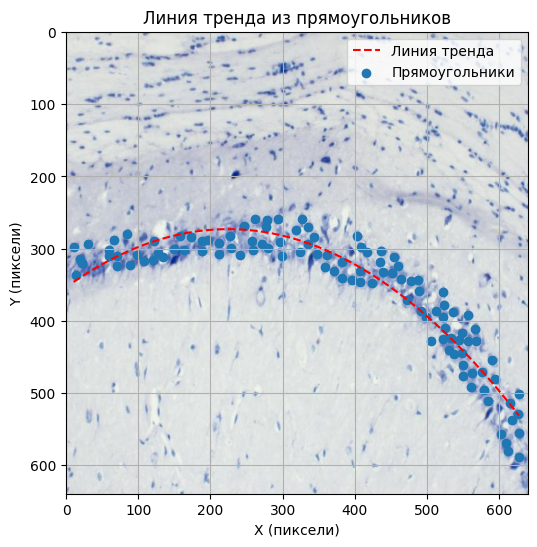

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка изображения
image = cv2.imread(image_path)

# Извлечение координат центров прямоугольников
x_values = [(rect[0] + rect[2]) / 2 for rect in annotations]
y_values = [(rect[1] + rect[3]) / 2 for rect in annotations]

# Выполнение линейной регрессии
p = np.polyfit(x_values, y_values, 2)

# Создание изогнутой линии тренда
x_trend_pixels = np.linspace(min(x_values), max(x_values), 100)
y_trend_pixels = np.polyval(p, x_trend_pixels)

# Построение графика линии тренда
plt.figure(figsize=(8, 6))
plt.plot(x_trend_pixels, y_trend_pixels, color='red', linestyle='--', label='Линия тренда')

# Наложение графика на изображение
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.scatter(x_values, y_values, label='Прямоугольники')
plt.xlabel('X (пиксели)')
plt.ylabel('Y (пиксели)')
plt.title('Линия тренда из прямоугольников')
plt.legend()
plt.grid(True)
plt.show()



In [12]:
# Функция для вычисления длины линии тренда
def trend_line_length(x_values, y_values):
    total_length = 0
    for i in range(1, len(x_values)):
        length = np.sqrt((x_values[i] - x_values[i-1])**2 + (y_values[i] - y_values[i-1])**2)
        total_length += length
    return total_length

# Пример использования
length = trend_line_length(x_values, y_values)
print("Длина линии тренда:", length)

Длина линии тренда: 2283.0274464688137


In [13]:
# Создаем массив значений X для которых будем вычислять Y на линии тренда
x_trend = np.linspace(min(x_values), max(x_values), 100)

# Вычисляем значения Y на линии тренда с использованием полинома
y_trend = np.polyval(p, x_trend)

# Выводим координаты линии тренда
print("Координаты линии тренда:")
for x, y in zip(x_trend, y_trend):
    print(f"({x}, {y})")

Координаты линии тренда:
(10.5, 346.1165558683156)
(16.732323232323232, 341.92480103502226)
(22.964646464646464, 337.8567470618828)
(29.1969696969697, 333.9123939488972)
(35.42929292929293, 330.0917416960655)
(41.661616161616166, 326.39479030338765)
(47.8939393939394, 322.8215397708637)
(54.12626262626263, 319.3719900984936)
(60.35858585858586, 316.0461412862774)
(66.5909090909091, 312.84399333421504)
(72.82323232323233, 309.7655462423066)
(79.05555555555556, 306.81080001055193)
(85.2878787878788, 303.97975463895125)
(91.52020202020202, 301.2724101275044)
(97.75252525252526, 298.68876647621136)
(103.98484848484848, 296.22882368507226)
(110.21717171717172, 293.892581754087)
(116.44949494949496, 291.6800406832556)
(122.68181818181819, 289.5912004725781)
(128.91414141414143, 287.62606112205447)
(135.14646464646466, 285.78462263168467)
(141.37878787878788, 284.0668850014688)
(147.61111111111111, 282.4728482314068)
(153.84343434343435, 281.0025123214986)
(160.0757575757576, 279.655877271744

Координаты линии тренда:


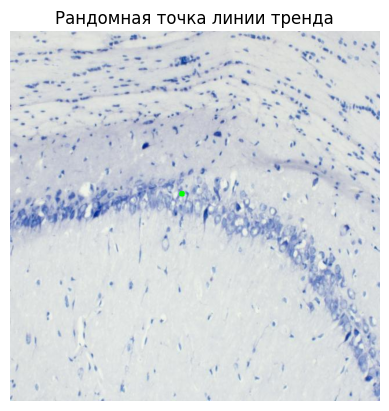

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Вычисление соотношения пикселей к миллиметрам
pixel_to_mm_ratio = (pixel_width_um / 1000) / image_width_px

# Функция для преобразования пикселей в миллиметры
def pixel_to_mm(x_pixel, y_pixel):
    x_mm = x_pixel * pixel_to_mm_ratio
    y_mm = y_pixel * pixel_to_mm_ratio
    return x_mm, y_mm

# Загрузка изображения
image = cv2.imread(image_path) 

# Создаем массив значений X для которых будем вычислять Y на линии тренда
x_trend = np.linspace(min(x_values), max(x_values), 100)

# Вычисляем значения Y на линии тренда с использованием полинома
y_trend = np.polyval(p, x_trend)

# Выводим координаты линии тренда
print("Координаты линии тренда:")
#for x, y in zip(x_trend, y_trend):
    #print(f"({x}, {y})")

# Находим координаты третьей точки линии тренда
third_point_index = random.randint(0, len(x_trend) - 1)  # Индексация начинается с 0, поэтому третья точка имеет индекс 2
third_point_x = x_trend[third_point_index]
third_point_y = y_trend[third_point_index]

# Отображаем третью точку на изображении
image_with_point = image.copy()
cv2.circle(image_with_point, (int(third_point_x), int(third_point_y)), 5, (0, 255, 0), -1)

# Отображение изображения с третьей точкой линии тренда
plt.imshow(cv2.cvtColor(image_with_point, cv2.COLOR_BGR2RGB))
plt.title('Рандомная точка линии тренда')
plt.axis('off')
plt.show()


Количество аннотаций в области интереса: 22


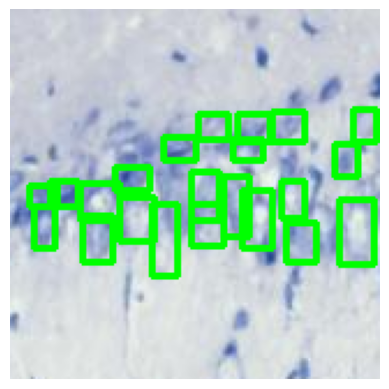

In [29]:
import cv2
import numpy as np
import random

# Вычисление соотношения пикселей к миллиметрам
pixel_to_mm_ratio = (pixel_width_um / 1000) / image_width_px

# Функция для преобразования пикселей в миллиметры
def pixel_to_mm(x_pixel, y_pixel):
    x_mm = x_pixel * pixel_to_mm_ratio
    y_mm = y_pixel * pixel_to_mm_ratio
    return x_mm, y_mm

# Загрузка изображения
image = cv2.imread(image_path)

# Выполнение линейной регрессии
p = np.polyfit(x_values, y_values, 2)


# Создаем массив значений X для которых будем вычислять Y на линии тренда
x_trend = np.linspace(min(x_values), max(x_values), 100)

# Вычисляем значения Y на линии тренда с использованием полинома
y_trend = np.polyval(p, x_trend)

# Размеры участка для вырезания 
# Тут получается в jpg оригинале 4095х3008 пикселей, для yolo мы сделали resize 640х640
# Итого получилось соотношение пикселя 0.1845
# Посчитав на оригинальном CYZ снимке количество пикселей на микрометры, пришел к выводу, что 300 мкм (это ~ 870 пикселей)
# Поэтому 870* 0,1845 ~ 161 px будет соответсвовать длине в 300 мкм на нашем 640х640 изображении

patch_size = 161
half_patch_size = patch_size // 2


# Определяем центр линии тренда
trend_center_x = int(np.mean(x_trend))
trend_center_y = int(np.mean(y_trend))

# Повторяем до тех пор, пока не найдем участок, содержащий линию тренда
while True:
    # Генерируем случайные смещения относительно центра линии тренда
    random_offset_x = random.randint(-half_patch_size, half_patch_size)
    random_offset_y = random.randint(-half_patch_size, half_patch_size)
    
    # Вычисляем координаты центра участка
    random_x = trend_center_x + random_offset_x
    random_y = trend_center_y + random_offset_y
    
    # Определяем границы участка
    top_left_x = random_x - half_patch_size
    top_left_y = random_y - half_patch_size
    bottom_right_x = random_x + half_patch_size
    bottom_right_y = random_y + half_patch_size
    
    # Проверяем, что участок полностью содержится в пределах изображения
    if (top_left_x >= 0 and top_left_y >= 0 and 
        bottom_right_x <= image.shape[1] and bottom_right_y <= image.shape[0]):
        # Вырезаем участок изображения
        patch = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        
        # Проверяем, содержит ли участок линию тренда (пример)
        if np.any(np.logical_and(top_left_x <= x_trend, x_trend <= bottom_right_x)) and \
           np.any(np.logical_and(top_left_y <= y_trend, y_trend <= bottom_right_y)):
            break

# Подсчет количества аннотаций в области обрезания
num_annotations_in_patch = 0
for annotation in annotations:
    x1, y1, x2, y2 = annotation
    # Проверка, попадает ли прямоугольник в область обрезания
    if x1 >= top_left_x and y1 >= top_left_y and x2 <= bottom_right_x and y2 <= bottom_right_y:
        num_annotations_in_patch += 1

print("Количество аннотаций в области интереса:", num_annotations_in_patch)

annotated_patch = patch.copy()

# Рисуем прямоугольники аннотаций на обрезанном участке изображения
for annotation in annotations:
    x1, y1, x2, y2 = annotation
    # Проверяем, попадает ли аннотация в область обрезания
    if x1 >= top_left_x and y1 >= top_left_y and x2 <= bottom_right_x and y2 <= bottom_right_y:
        # Рисуем прямоугольник
        cv2.rectangle(annotated_patch, (x1 - top_left_x, y1 - top_left_y), (x2 - top_left_x, y2 - top_left_y), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(annotated_patch, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
